# STATE OF CHARGE PREDICTION

72 real driving trips with a BMW i3 (60 Ah) were recorded, serving for model validation of a full vehicle model consisting of the powertrain and the heating circuit.

https://www.kaggle.com/datasets/atechnohazard/battery-and-heating-data-in-real-driving-cycles

In [3]:
import pandas as pd
import numpy as np
import os, chardet, glob
import matplotlib.pyplot as plt
import seaborn

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score   
from sklearn.svm import SVC
from sklearn.datasets import load_iris  

import tensorflow as tf
from tensorflow.keras import Sequential, optimizers, losses, layers

%matplotlib inline

In [4]:
df_overview = pd.read_excel(r'C:\Users\vishn\Downloads\mod\Overview.xlsx')
df_overview = df_overview.drop(['Unnamed: 13','Note'], axis=1)
df_overview = df_overview.dropna()
df_overview.rename(columns = {'Unnamed: 8':'SoC difference'}, inplace = True)
df_overview.head()

,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),SoC difference,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Fan
0,TripA01,2019-06-25_13-21-14,Munich East,sunny,21.0,22.0,0.863,0.803,0.060,25.5,23.0,7.427690,16.820000,"Automatic, Level 1"
1,TripA02,2019-06-25_14-05-31,Munich East,sunny,23.0,26.0,0.803,0.673,0.130,32.0,23.0,23.509709,23.550000,"Automatic, Level 1"
2,TripA03,2019-06-28_10-02-15,Munich East,sunny,24.0,25.0,0.835,0.751,0.084,21.5,27.0,12.820846,11.180000,"Automatic, Level 1"
3,TripA04,2019-06-28_10-13-30,Munich East,sunny,25.0,27.0,0.751,0.667,0.084,24.0,22.0,10.727491,6.870000,"Automatic, Level 1"
4,TripA05,2019-06-28_10-20-26,Munich East,sunny,27.0,27.0,0.667,0.602,0.065,24.5,24.0,12.393223,22.776667,"Automatic, Level 1"


In [5]:
def combine_csvs():
    ''' Combine all csv datasets into a single file'''
    df_master = pd.DataFrame()
    for filename in glob.glob(r'C:\Users\vishn\Downloads\AllTrips.csv'+'*.csv'):
        df_trip = pd.read_csv(
            filename,
            sep=';',
            encoding=chardet.detect(open(filename, 'rb').read())['encoding']
        )
        df_master = pd.concat([df_master, df_trip])
        df_master.to_csv(r'C:\Users\vishn\Downloads\AllTrips.csv', index=False)
    return df_master


def plot_dataframe_subplots(df, nrows, ncols, figsize=(30, 24)):
    """Plot a nrows x ncols grid of the df variables"""
    measurements = list(df.columns)
    plt.figure(figsize=figsize)
    for idx, key in enumerate(measurements):
        plt.subplot(nrows, ncols, idx+1)
        plt.plot(np.array(range(df.shape[0]))*0.1, df[key])
        plt.ylabel(key)
        plt.grid(True)
        plt.xlabel(measurements[0])
        plt.show

In [27]:
# Load in the dataset
if os.path.exists(r'C:\Users\vishn\Downloads\AllTrips.csv'):
    df_master = pd.read_csv(r'C:\Users\vishn\Downloads\AllTrips.csv')
else: df_master = combine_csvs()

# Remove last 2 columns since they are Nan
df_master = df_master.iloc[: , :-2]
print(list(df_master.columns.values))

['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]', 'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]', 'Regenerative Braking Signal ', 'Battery Voltage [V]', 'Battery Current [A]', 'Battery Temperature [°C]', 'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]', 'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]', 'Requested Heating Power [W]', 'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]', 'Requested Coolant Temperature [°C]', 'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]', 'Velocity [km/h]]]', 'Heating Power LIN [W]', 'Heater Voltage [V]', 'Heater Current [A]', 'Ambient Temperature Sensor [°C]', 'Coolant Temperature Heatercore [°C]', 'Coolant Temperature Inlet [°C]', 'Coolant Volume Flow +500 [l/h]', 'Temperature Coolant Heater Inlet [°C]', 'Temperature Coolant Heater Outlet [°C]', 'Temperature Heat Exchanger Outlet [°C]', 'Temperature Defrost lateral left [°C]', 'Temperature Defrost lateral right [°C]', 'Temp

In [7]:
df_master.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Defrost central right [°C],Temperature Footweel Driver [°C],Temperature Footweel Co-Driver [°C],Temperature Feetvent Co-Driver [°C],Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C]
0,0.0,0.0,547.0,0.0,0.0,-0.05,0.0,384.1,-5.70,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,0.0,547.0,0.0,0.0,-0.07,0.0,384.1,-5.70,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.2,0.0,547.0,0.0,0.0,-0.09,0.0,384.1,-5.70,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.3,0.0,547.0,0.0,0.0,-0.10,0.0,384.1,-5.70,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.4,0.0,547.0,0.0,0.0,-0.07,0.0,384.1,-5.73,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
import pandas as pd
# get columns with NaN values
cols_with_nan = df_master.columns[df_master.isna().any()].tolist()

# print out columns with NaN values and how many NaN values they have
for col in cols_with_nan:
    print(col, "has", df_master[col].isna().sum(), "NaN values")

Velocity [km/h] has 16429 NaN values
SoC [%] has 30793 NaN values
displayed SoC [%] has 30794 NaN values
min. SoC [%] has 30793 NaN values
max. SoC [%) has 30794 NaN values
Requested Coolant Temperature [°C] has 19829 NaN values
Velocity [km/h]]] has 1078364 NaN values
Heating Power LIN [W] has 310587 NaN values
Heater Voltage [V] has 310587 NaN values
Heater Current [A] has 310587 NaN values
Ambient Temperature Sensor [°C] has 472340 NaN values
Coolant Temperature Heatercore [°C] has 310587 NaN values
Coolant Temperature Inlet [°C] has 310587 NaN values
Coolant Volume Flow +500 [l/h] has 496034 NaN values
Temperature Coolant Heater Inlet [°C] has 472340 NaN values
Temperature Coolant Heater Outlet [°C] has 472340 NaN values
Temperature Heat Exchanger Outlet [°C] has 472340 NaN values
Temperature Defrost lateral left [°C] has 472340 NaN values
Temperature Defrost lateral right [°C] has 472340 NaN values
Temperature Defrost central [°C] has 472340 NaN values
Temperature Defrost central 

In [29]:
dftest=df_master.drop(['Ambient Temperature Sensor [°C]','Coolant Temperature Heatercore [°C]', 'Coolant Temperature Inlet [°C]',
       'Coolant Volume Flow +500 [l/h]',
       'Temperature Coolant Heater Inlet [°C]',
       'Temperature Coolant Heater Outlet [°C]',
       'Temperature Heat Exchanger Outlet [°C]',
       'Temperature Defrost lateral left [°C]',
       'Temperature Defrost lateral right [°C]',
       'Temperature Defrost central [°C]',
       'Temperature Defrost central left [°C]',
       'Temperature Defrost central right [°C]',
       'Temperature Footweel Driver [°C]',
       'Temperature Footweel Co-Driver [°C]',
       'Temperature Feetvent Co-Driver [°C]',
       'Temperature Feetvent Driver [°C]', 'Temperature Head Co-Driver [°C]',
       'Temperature Head Driver [°C]', 'Temperature Vent right [°C] ',
       'Temperature Vent central right [°C]',
       'Temperature Vent central left [°C]','Velocity [km/h]]]'],axis=1)
dftest

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Requested Heating Power [W],AirCon Power [kW],Heater Signal,Ambient Temperature [°C],Requested Coolant Temperature [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C],Heating Power LIN [W],Heater Voltage [V],Heater Current [A]
0,0.0,0.0,547.0,0.0,0.0,-0.05000,0.0,384.1,-5.70000,22.0,...,0.0,1.64,1,22.5,85.0,15.5,38.1700,NaN,NaN,NaN
1,0.1,0.0,547.0,0.0,0.0,-0.07000,0.0,384.1,-5.70000,22.0,...,0.0,1.64,1,22.5,85.0,15.5,38.1700,NaN,NaN,NaN
2,0.2,0.0,547.0,0.0,0.0,-0.09000,0.0,384.1,-5.70000,22.0,...,0.0,1.64,1,22.5,85.0,15.5,38.1700,NaN,NaN,NaN
3,0.3,0.0,547.0,0.0,0.0,-0.10000,0.0,384.1,-5.70000,22.0,...,0.0,1.64,1,22.5,85.0,15.5,38.1700,NaN,NaN,NaN
4,0.4,0.0,547.0,0.0,0.0,-0.07000,0.0,384.1,-5.73000,22.0,...,0.0,1.64,1,22.5,85.0,15.5,38.1700,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094788,1396.9,0.0,563.0,0.0,0.0,-0.05200,0.0,388.9,-0.84034,20.0,...,0.0,0.00,1,20.0,85.0,21.0,25.5051,0.0,392.0,0.0
1094789,1397.0,0.0,563.0,0.0,0.0,-0.03539,0.0,388.9,-0.80966,20.0,...,0.0,0.00,1,20.0,85.0,21.0,25.5051,0.0,392.0,0.0
1094790,1397.1,0.0,563.0,0.0,0.0,-0.03200,0.0,388.9,-0.85966,20.0,...,0.0,0.00,1,20.0,85.0,21.0,25.5051,0.0,392.0,0.0
1094791,1397.2,0.0,563.0,0.0,0.0,-0.04862,0.0,388.9,-0.90000,20.0,...,0.0,0.00,1,20.0,85.0,21.0,25.5051,0.0,392.0,0.0


In [10]:
print(list(dftest.columns.values))

['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]', 'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]', 'Regenerative Braking Signal ', 'Battery Voltage [V]', 'Battery Current [A]', 'Battery Temperature [°C]', 'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]', 'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]', 'Requested Heating Power [W]', 'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]', 'Requested Coolant Temperature [°C]', 'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]']


In [30]:
import pandas as pd
# get columns with NaN values
cols_with_nan = dftest.columns[dftest.isna().any()].tolist()

# print out columns with NaN values and how many NaN values they have
for col in cols_with_nan:
    print(col, "has", dftest[col].isna().sum(), "NaN values")

Velocity [km/h] has 16429 NaN values
SoC [%] has 30793 NaN values
displayed SoC [%] has 30794 NaN values
min. SoC [%] has 30793 NaN values
max. SoC [%) has 30794 NaN values
Requested Coolant Temperature [°C] has 19829 NaN values
Heating Power LIN [W] has 310587 NaN values
Heater Voltage [V] has 310587 NaN values
Heater Current [A] has 310587 NaN values


In [31]:
# replace NaN values with mean values for each column
dftest = dftest.fillna(dftest.mean())

# alternatively, replace NaN values with interpolated values
# df = df.interpolate()

# print the first five rows of the updated dataframe
print(dftest.head())

   Time [s]  Velocity [km/h]  Elevation [m]  Throttle [%]  Motor Torque [Nm]  \
0       0.0              0.0          547.0           0.0                0.0   
1       0.1              0.0          547.0           0.0                0.0   
2       0.2              0.0          547.0           0.0                0.0   
3       0.3              0.0          547.0           0.0                0.0   
4       0.4              0.0          547.0           0.0                0.0   

   Longitudinal Acceleration [m/s^2]  Regenerative Braking Signal   \
0                              -0.05                           0.0   
1                              -0.07                           0.0   
2                              -0.09                           0.0   
3                              -0.10                           0.0   
4                              -0.07                           0.0   

   Battery Voltage [V]  Battery Current [A]  Battery Temperature [°C]  ...  \
0                384

In [33]:
# replace NaN values with mean values for each column
dftest = dftest.fillna(dftest.mean())

# alternatively, replace NaN values with interpolated values
# dftest = dftest.interpolate()

# print the first five rows of the updated dataframe
print(dftest.head())

   Time [s]  Velocity [km/h]  Elevation [m]  Throttle [%]  Motor Torque [Nm]  \
0       0.0              0.0          547.0           0.0                0.0   
1       0.1              0.0          547.0           0.0                0.0   
2       0.2              0.0          547.0           0.0                0.0   
3       0.3              0.0          547.0           0.0                0.0   
4       0.4              0.0          547.0           0.0                0.0   

   Longitudinal Acceleration [m/s^2]  Regenerative Braking Signal   \
0                              -0.05                           0.0   
1                              -0.07                           0.0   
2                              -0.09                           0.0   
3                              -0.10                           0.0   
4                              -0.07                           0.0   

   Battery Voltage [V]  Battery Current [A]  Battery Temperature [°C]  ...  \
0                384

In [12]:
dftest=dftest.dropna()

In [32]:
import pandas as pd
# get columns with NaN values
cols_with_nan = dftest.columns[dftest.isna().any()].tolist()

# print out columns with NaN values and how many NaN values they have
for col in cols_with_nan:
    print(col, "has", dftest[col].isna().sum(), "NaN values")

In [33]:
print(list(dftest.columns.values))

['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]', 'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]', 'Regenerative Braking Signal ', 'Battery Voltage [V]', 'Battery Current [A]', 'Battery Temperature [°C]', 'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]', 'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]', 'Requested Heating Power [W]', 'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]', 'Requested Coolant Temperature [°C]', 'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]', 'Heating Power LIN [W]', 'Heater Voltage [V]', 'Heater Current [A]']


In [34]:
def set_negative_plot_color():
    plt.figure(figsize=(30, 6), facecolor='black')
    ax = plt.axes()
    ax.set_facecolor("black")
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(colors='white', which='both')
    plt.grid(True)
def regression_metrics(y_test, y_pred):
    # calculate errors
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    eps = 1e-10 # a small value to avoid division by zero
    rmspe = np.sqrt(np.mean(np.square(((y_test - y_pred) / (y_test + eps)))))
    #rmspe = np.sqrt(np.mean(np.square(((y_test - y_pred)/y_test)), axis=0))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    # report error
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Square Error: {rmse}')
    print(f'Root Mean Square Percentage Error: {rmspe}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Absolute Percentage Error: {mape}')


def plot_comparison(y_test, y_pred, xlabel, ylabel, dark_mode=False, figsize=(30, 6)):
    if dark_mode:
        plt.figure(figsize=figsize, facecolor='black')
        ax = plt.axes()
        ax.set_facecolor("black")
        ax.spines['bottom'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['right'].set_color('gray')
        ax.spines['left'].set_color('gray')
        ax.tick_params(colors='white', which='both')
        plt.plot(y_pred, color="yellow")
        plt.plot(y_test, color="white")
        plt.legend(['Predicted', 'Measured'])
        plt.xlabel(xlabel, color='white')
        plt.ylabel(ylabel, color='white')
    else:
        plt.figure(figsize=figsize)
        plt.plot(y_pred)
        plt.plot(y_test)        
        plt.legend(['Predicted', 'Measured'])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.grid(True)

FREATURE SELECTION

In [20]:
X=dftest.drop(['SoC [%]'],axis=1)
y= dftest['SoC [%]']

In [21]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

# define the random forest regressor
rf = RandomForestRegressor(n_jobs=-1, max_depth=10)

# define the Boruta feature selection object
boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=1, random_state=1)

# fit the Boruta feature selector to the training data
boruta_feature_selector.fit(X.values, y.values.ravel())

# print the top features selected by the Boruta feature selector
top_features = X.columns[boruta_feature_selector.support_].tolist()
print(top_features)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100


BorutaPy finished running.

Iteration: 	30 / 100
Confirmed: 	22
Tentative: 	0
Rejected: 	0
['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]', 'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]', 'Regenerative Braking Signal ', 'Battery Voltage [V]', 'Battery Current [A]', 'Battery Temperature [°C]', 'max. Battery Temperature [°C]', 'displayed SoC [%]', 'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [k

TRAINING AND PREDICTION

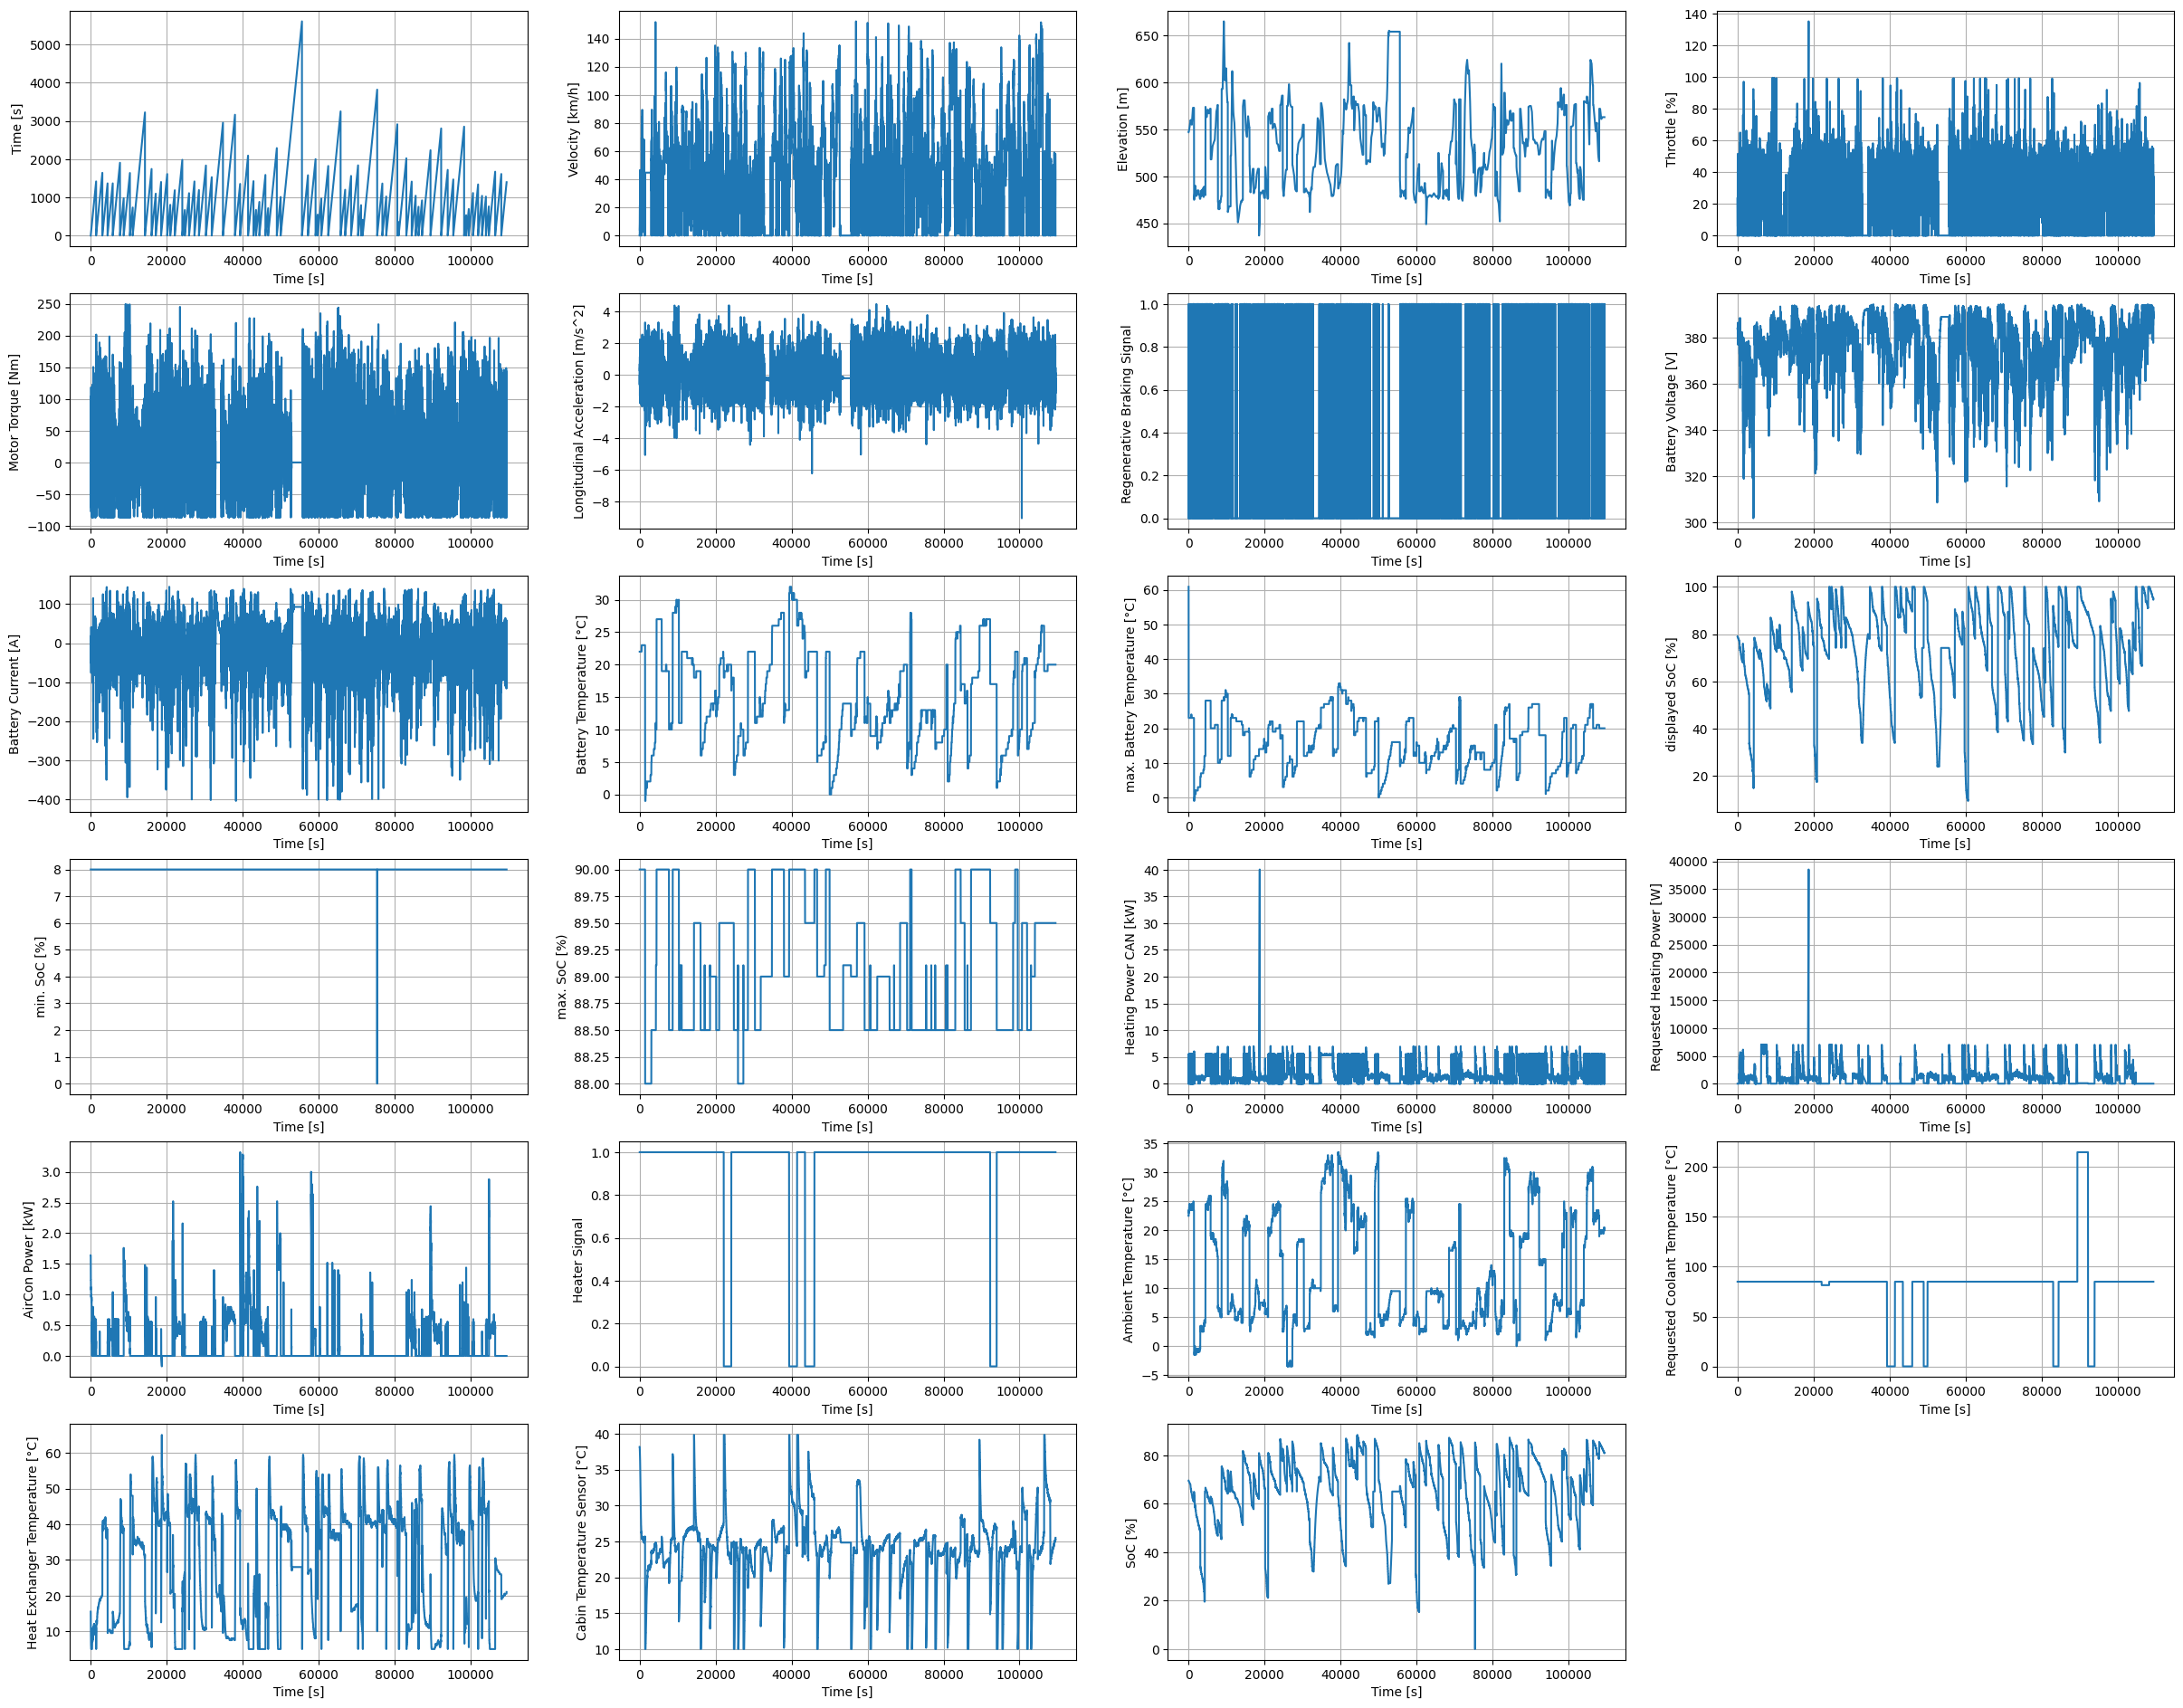

In [38]:
df_x_y = dftest[['Time [s]', 'Velocity [km/h]', 'Elevation [m]',
                 'Throttle [%]', 'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
                 'Regenerative Braking Signal ', 'Battery Voltage [V]', 'Battery Current [A]',
                 'Battery Temperature [°C]', 'max. Battery Temperature [°C]', 'displayed SoC [%]',
                 'min. SoC [%]','max. SoC [%)', 'Heating Power CAN [kW]', 'Requested Heating Power [W]',
                 'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]', 'Requested Coolant Temperature [°C]',
                 'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]','SoC [%]']].dropna()

plot_dataframe_subplots(df_x_y, nrows=12, ncols=4, figsize=(30, 48))

In [16]:
# Create and split train and test datasets
X = d_x_y.drop(['Time [s]','SoC [%]'], axis=1)
y = df_x_y[['SoC [%]']]
splitter = int(len(X)*0.7)
X_train = X.values[:splitter]
X_test = X.values[splitter:]
y_train = y.values[:splitter]
y_test = y.values[splitter:]
# Check the dataset sizes
X_train.shape, y_train.shape, X_test.shape, y_test.shape[0]

((515888, 24),
 (515888, 1),
 (110548, 24),
 (110548, 1),
 (110547, 24),
 (110547, 1))

In [15]:
# Create and split train and test datasets
X = df_x_y.drop(['Time [s]','SoC [%]'], axis=1)
y = df_x_y[['SoC [%]']]
splitter = int(len(X)*0.8)
X_train = X.values[:splitter]
splitter2 = int(len(X_train)*0.8)
X_train = X.values[:splitter2]
X_val = X.values[splitter2:splitter]
X_test = X.values[splitter:]
y_train = y.values[:splitter2]
y_val = y.values[splitter2:splitter]
y_test = y.values[splitter:]
# Check the dataset sizes
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((657753, 20),
 (657753, 1),
 (205549, 20),
 (205549, 1),
 (164439, 20),
 (164439, 1))

In [39]:
# Create and split train and test datasets
X = df_x_y.drop(['Time [s]','SoC [%]'], axis=1)
y = df_x_y[['SoC [%]']]
splitter = int(len(X)*0.7)
splitter2 = int(len(X)*0.85)
X_train = X.values[:splitter]
X_val = X.values[splitter:splitter2]
X_test = X.values[splitter2:]
y_train = y.values[:splitter]
y_val = y.values[splitter:splitter2]
y_test = y.values[splitter2:]
# Check the dataset sizes
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((766355, 21),
 (766355, 1),
 (164219, 21),
 (164219, 1),
 (164219, 21),
 (164219, 1))

GRU+BILSTM WITH zscore and L1/L2 REGURALIZATIONS

Epoch 1/20
16122/16122 [==============================] - 115s 7ms/step - loss: 7.7959 - mae: 7.1799 - val_loss: 3.8736 - val_mae: 3.1326
Epoch 2/20
16122/16122 [==============================] - 110s 7ms/step - loss: 1.5015 - mae: 0.8112 - val_loss: 1.9819 - val_mae: 1.3745
Epoch 3/20
16122/16122 [==============================] - 112s 7ms/step - loss: 1.1577 - mae: 0.6083 - val_loss: 1.8261 - val_mae: 1.3255
Epoch 4/20
16122/16122 [==============================] - 110s 7ms/step - loss: 1.0203 - mae: 0.5565 - val_loss: 1.7705 - val_mae: 1.3391
Epoch 5/20
16122/16122 [==============================] - 113s 7ms/step - loss: 0.9282 - mae: 0.5226 - val_loss: 1.7020 - val_mae: 1.3193
Epoch 6/20
16122/16122 [==============================] - 111s 7ms/step - loss: 0.8568 - mae: 0.4927 - val_loss: 1.6424 - val_mae: 1.2956
Epoch 7/20
16122/16122 [==============================] - 116s 7ms/step - loss: 0.7983 - mae: 0.4664 - val_loss: 1.6399 - val_mae: 1.3217
Epoch 8/20
16122/16122 [==========

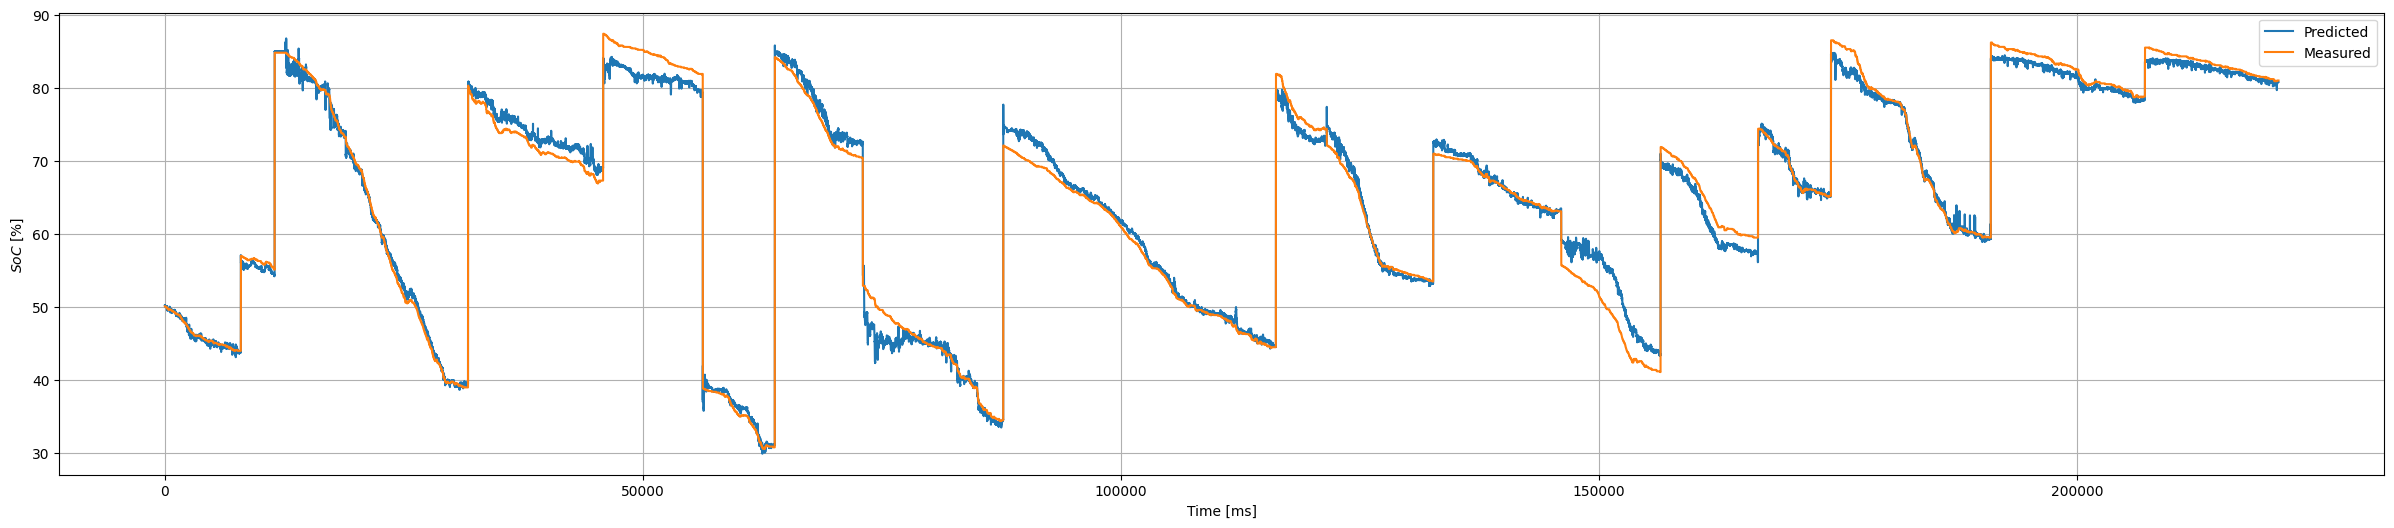

In [11]:
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Bidirectional, LSTM, Dense, Flatten, TimeDistributed

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the training data
X_train_norm = scaler.fit_transform(X_train)
# Normalize the testing data using the same scaler object
X_test_norm = scaler.transform(X_test)

# Define the GRU model with L1 regularization
gru_model = Sequential([
    layers.GRU(64, input_shape=(X_train_norm.shape[1], 1),
               kernel_regularizer=regularizers.l1(0.01)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
])

# Define the Bi-LSTM model with one LSTM layer and L1/L2 regularization
lstm_input = Input(shape=(X_train_norm.shape[1], 1))
lstm_layer = Bidirectional(LSTM(32, return_sequences=True,
                                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))(lstm_input)
lstm_layer = TimeDistributed(Dense(16, activation='relu',
                                   kernel_regularizer=regularizers.l2(0.01)))(lstm_layer)
lstm_layer = Flatten()(lstm_layer)

# Combine the two models
combined_layer = concatenate([gru_model.output, lstm_layer])
final_layer = Dense(1)(combined_layer)
combined_model = Model(inputs=[gru_model.input, lstm_input], outputs=final_layer)

# Compile the model with early stopping
combined_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                       loss=losses.mae,
                       metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Train the model
history = combined_model.fit([X_train_norm, X_train_norm], y_train, epochs=20, verbose=1,
                             validation_data=([X_test_norm, X_test_norm], y_test),
                             callbacks=[early_stopping])

# Make predictions on the test set
y_pred_combined = combined_model.predict([X_test_norm, X_test_norm])

# Print the regression metrics and plot the results
print('Combined Model (GRU + Bi-LSTM):')
regression_metrics(y_test, y_pred_combined)
plot_comparison(y_test=y_test, y_pred=y_pred_combined, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)


Epoch 1/50
23949/23949 [==============================] - 157s 6ms/step - loss: 6.1866 - mae: 5.5501 - val_loss: 2.0296 - val_mae: 1.3980
Epoch 2/50
23949/23949 [==============================] - 171s 7ms/step - loss: 1.1620 - mae: 0.6333 - val_loss: 1.6410 - val_mae: 1.1892
Epoch 3/50
23949/23949 [==============================] - 163s 7ms/step - loss: 0.9078 - mae: 0.5058 - val_loss: 1.4843 - val_mae: 1.1241
Epoch 4/50
23949/23949 [==============================] - 151s 6ms/step - loss: 0.7840 - mae: 0.4548 - val_loss: 1.4137 - val_mae: 1.1108
Epoch 5/50
23949/23949 [==============================] - 156s 7ms/step - loss: 0.7027 - mae: 0.4196 - val_loss: 1.3653 - val_mae: 1.0996
Epoch 6/50
23949/23949 [==============================] - 152s 6ms/step - loss: 0.6421 - mae: 0.3907 - val_loss: 1.3444 - val_mae: 1.1055
Epoch 7/50
23949/23949 [==============================] - 154s 6ms/step - loss: 0.5938 - mae: 0.3654 - val_loss: 1.3354 - val_mae: 1.1165
Epoch 8/50
23949/23949 [==========

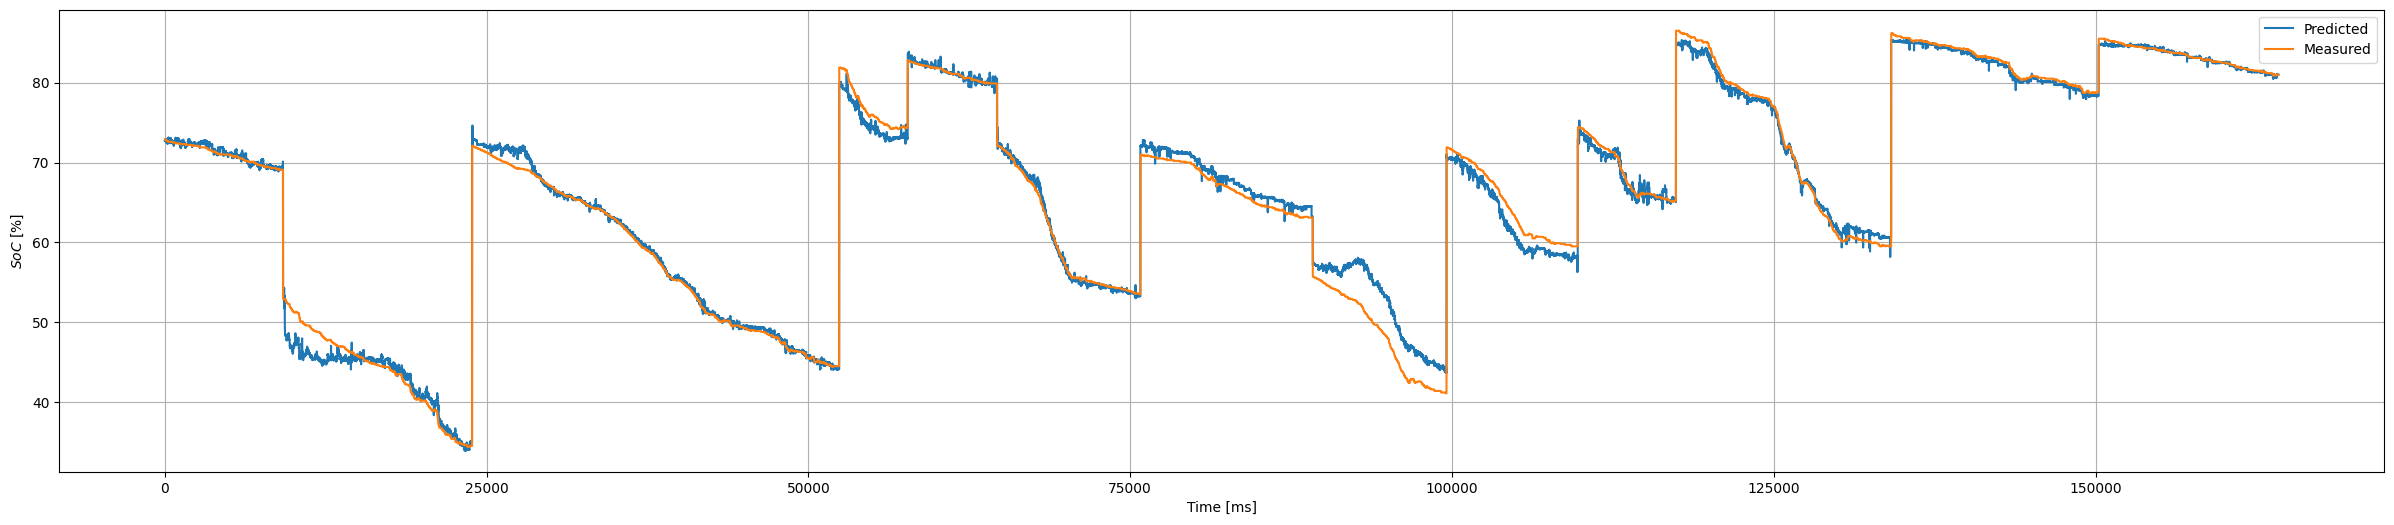

In [28]:
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Bidirectional, LSTM, Dense, Flatten, TimeDistributed

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the training data
X_train_norm = scaler.fit_transform(X_train)
# Normalize the testing data using the same scaler object
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

# Define the GRU model with L1 regularization
gru_model = Sequential([
    layers.GRU(64, input_shape=(X_train_norm.shape[1], 1),
               kernel_regularizer=regularizers.l1(0.01)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
])

# Define the Bi-LSTM model with one LSTM layer and L1/L2 regularization
lstm_input = Input(shape=(X_train_norm.shape[1], 1))
lstm_layer = Bidirectional(LSTM(32, return_sequences=True,
                                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))(lstm_input)
lstm_layer = TimeDistributed(Dense(16, activation='relu',
                                   kernel_regularizer=regularizers.l2(0.01)))(lstm_layer)
lstm_layer = Flatten()(lstm_layer)

# Combine the two models
combined_layer = concatenate([gru_model.output, lstm_layer])
final_layer = Dense(1)(combined_layer)
combined_model = Model(inputs=[gru_model.input, lstm_input], outputs=final_layer)

# Compile the model with early stopping
combined_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                       loss=losses.mae,
                       metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
# Train the model
history = combined_model.fit([X_train_norm, X_train_norm], y_train, epochs=50, verbose=1,
                             validation_data=([X_val_norm, X_val_norm], y_val),
                             callbacks=[early_stopping])

# Make predictions on the test set
y_pred_combined = combined_model.predict([X_test_norm, X_test_norm])

# Print the regression metrics and plot the results
print('Combined Model (GRU + Bi-LSTM):')
regression_metrics(y_test, y_pred_combined)
plot_comparison(y_test=y_test, y_pred=y_pred_combined, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)


In [44]:
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Bidirectional, LSTM, Dense, Flatten, TimeDistributed

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the training data
X_train_norm = scaler.fit_transform(X_train)
# Normalize the testing data using the same scaler object
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

# Define the GRU model with L1 regularization
gru_model = Sequential([
    layers.GRU(64, input_shape=(X_train_norm.shape[1], 1),
               kernel_regularizer=regularizers.l1(0.01)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
])

# Define the Bi-LSTM model with one LSTM layer and L1/L2 regularization
lstm_input = Input(shape=(X_train_norm.shape[1], 1))
lstm_layer = Bidirectional(LSTM(32, return_sequences=True,
                                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))(lstm_input)
lstm_layer = TimeDistributed(Dense(16, activation='relu',
                                   kernel_regularizer=regularizers.l2(0.01)))(lstm_layer)
lstm_layer = Flatten()(lstm_layer)

# Combine the two models
combined_layer = concatenate([gru_model.output, lstm_layer])
final_layer = Dense(1)(combined_layer)
combined_model = Model(inputs=[gru_model.input, lstm_input], outputs=final_layer)

# Compile the model with early stopping
combined_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                       loss=losses.mae,
                       metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
# Train the model
history = combined_model.fit([X_train_norm, X_train_norm], y_train, epochs=20, verbose=1,
                             validation_data=([X_val_norm, X_val_norm], y_val),
                             callbacks=[early_stopping])

# Make predictions on the test set
y_pred_combined = combined_model.predict([X_test_norm, X_test_norm])

# Print the regression metrics and plot the results
print('Combined Model (GRU + Bi-LSTM):')
regression_metrics(y_test, y_pred_combined)
plot_comparison(y_test=y_test, y_pred=y_pred_combined, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)


Epoch 1/20
  298/23949 [..............................] - ETA: 7:04 - loss: 45.3566 - mae: 43.5572

KeyboardInterrupt: 

Epoch 1/50
27370/27370 [==============================] - 163s 6ms/step - loss: 5.6817 - mae: 4.9955 - val_loss: 1.5556 - val_mae: 0.8591
Epoch 2/50
27370/27370 [==============================] - 157s 6ms/step - loss: 1.3030 - mae: 0.7215 - val_loss: 1.2713 - val_mae: 0.7745
Epoch 3/50
27370/27370 [==============================] - 155s 6ms/step - loss: 1.0661 - mae: 0.6228 - val_loss: 1.1415 - val_mae: 0.7430
Epoch 4/50
27370/27370 [==============================] - 161s 6ms/step - loss: 0.9301 - mae: 0.5629 - val_loss: 1.0109 - val_mae: 0.6713
Epoch 5/50
27370/27370 [==============================] - 155s 6ms/step - loss: 0.8363 - mae: 0.5187 - val_loss: 0.8932 - val_mae: 0.5951
Epoch 6/50
27370/27370 [==============================] - 155s 6ms/step - loss: 0.7602 - mae: 0.4782 - val_loss: 0.8225 - val_mae: 0.5548
Epoch 7/50
27370/27370 [==============================] - 155s 6ms/step - loss: 0.6998 - mae: 0.4436 - val_loss: 0.8185 - val_mae: 0.5732
Epoch 8/50
27370/27370 [==========

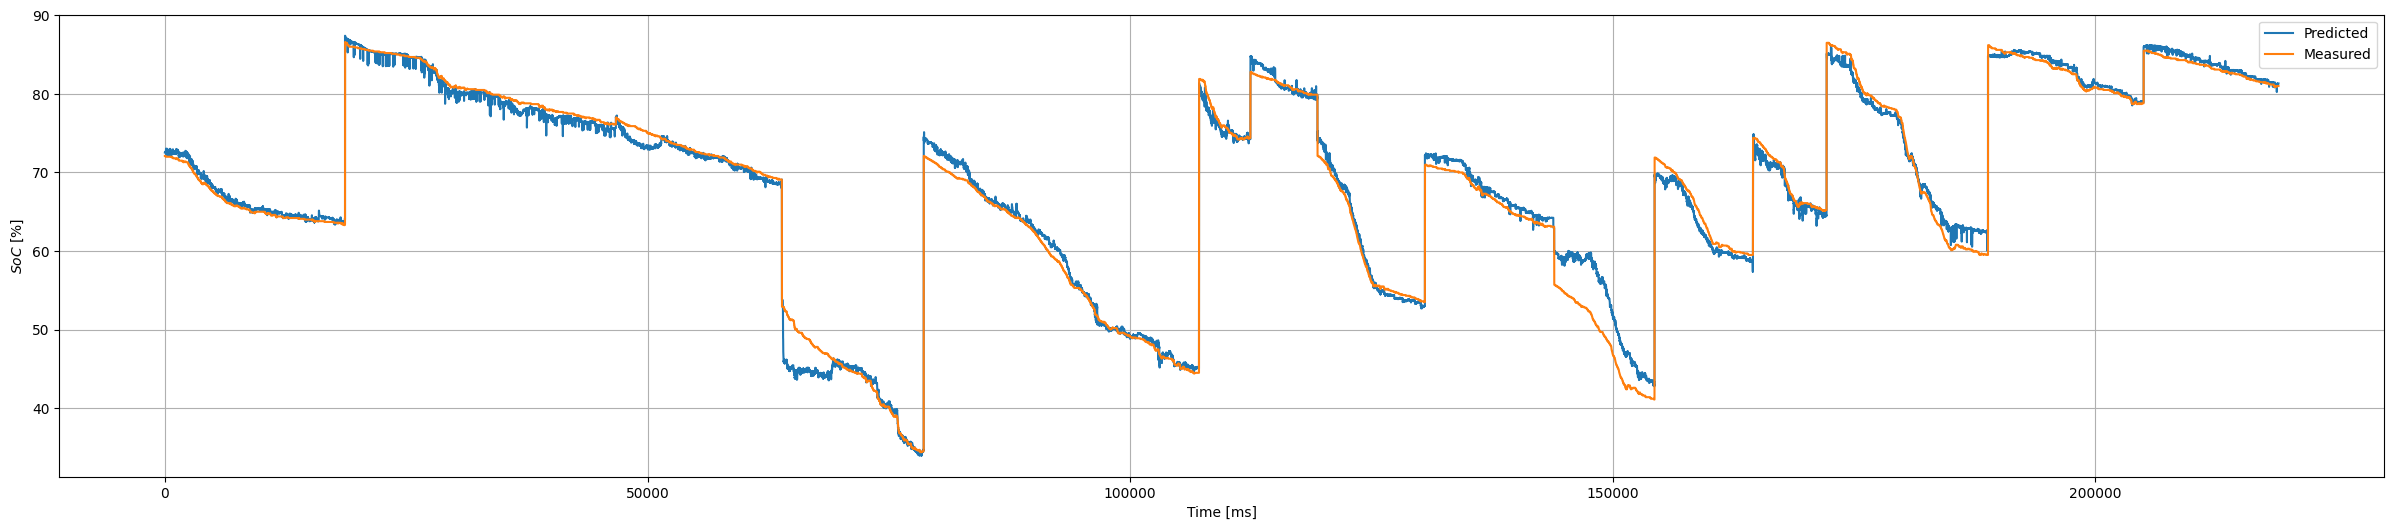

In [27]:
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Bidirectional, LSTM, Dense, Flatten, TimeDistributed

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the training data
X_train_norm = scaler.fit_transform(X_train)
# Normalize the testing data using the same scaler object
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

# Define the GRU model with L1 regularization
gru_model = Sequential([
    layers.GRU(64, input_shape=(X_train_norm.shape[1], 1),
               kernel_regularizer=regularizers.l1(0.01)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
])

# Define the Bi-LSTM model with one LSTM layer and L1/L2 regularization
lstm_input = Input(shape=(X_train_norm.shape[1], 1))
lstm_layer = Bidirectional(LSTM(32, return_sequences=True,
                                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))(lstm_input)
lstm_layer = TimeDistributed(Dense(16, activation='relu',
                                   kernel_regularizer=regularizers.l2(0.01)))(lstm_layer)
lstm_layer = Flatten()(lstm_layer)

# Combine the two models
combined_layer = concatenate([gru_model.output, lstm_layer])
final_layer = Dense(1)(combined_layer)
combined_model = Model(inputs=[gru_model.input, lstm_input], outputs=final_layer)

# Compile the model with early stopping
combined_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                       loss=losses.mae,
                       metrics=["mae"])

early_stopping = EarlyStopping(monitor='val_loss', patience=4)
# Train the model
history = combined_model.fit([X_train_norm, X_train_norm], y_train, epochs=50, verbose=1,
                             validation_data=([X_val_norm, X_val_norm], y_val),
                             callbacks=[early_stopping])

# Make predictions on the test set
y_pred_combined = combined_model.predict([X_test_norm, X_test_norm])

# Print the regression metrics and plot the results
print('Combined Model (GRU + Bi-LSTM):')
regression_metrics(y_test, y_pred_combined)
plot_comparison(y_test=y_test, y_pred=y_pred_combined, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)

Epoch 1/20
16122/16122 [==============================] - 104s 6ms/step - loss: 8.3776 - mae: 7.8332 - val_loss: 9.5229 - val_mae: 8.9837
Epoch 2/20
16122/16122 [==============================] - 100s 6ms/step - loss: 2.5273 - mae: 1.8343 - val_loss: 2.1138 - val_mae: 1.4546
Epoch 3/20
16122/16122 [==============================] - 99s 6ms/step - loss: 1.2751 - mae: 0.6767 - val_loss: 1.7303 - val_mae: 1.1845
Epoch 4/20
16122/16122 [==============================] - 98s 6ms/step - loss: 1.0759 - mae: 0.5715 - val_loss: 1.6144 - val_mae: 1.1472
Epoch 5/20
16122/16122 [==============================] - 99s 6ms/step - loss: 0.9578 - mae: 0.5204 - val_loss: 1.5790 - val_mae: 1.1678
Epoch 6/20
16122/16122 [==============================] - 99s 6ms/step - loss: 0.8689 - mae: 0.4796 - val_loss: 1.4680 - val_mae: 1.0984
Epoch 7/20
16122/16122 [==============================] - 98s 6ms/step - loss: 0.7952 - mae: 0.4433 - val_loss: 1.4135 - val_mae: 1.0775
Epoch 8/20
16122/16122 [===============

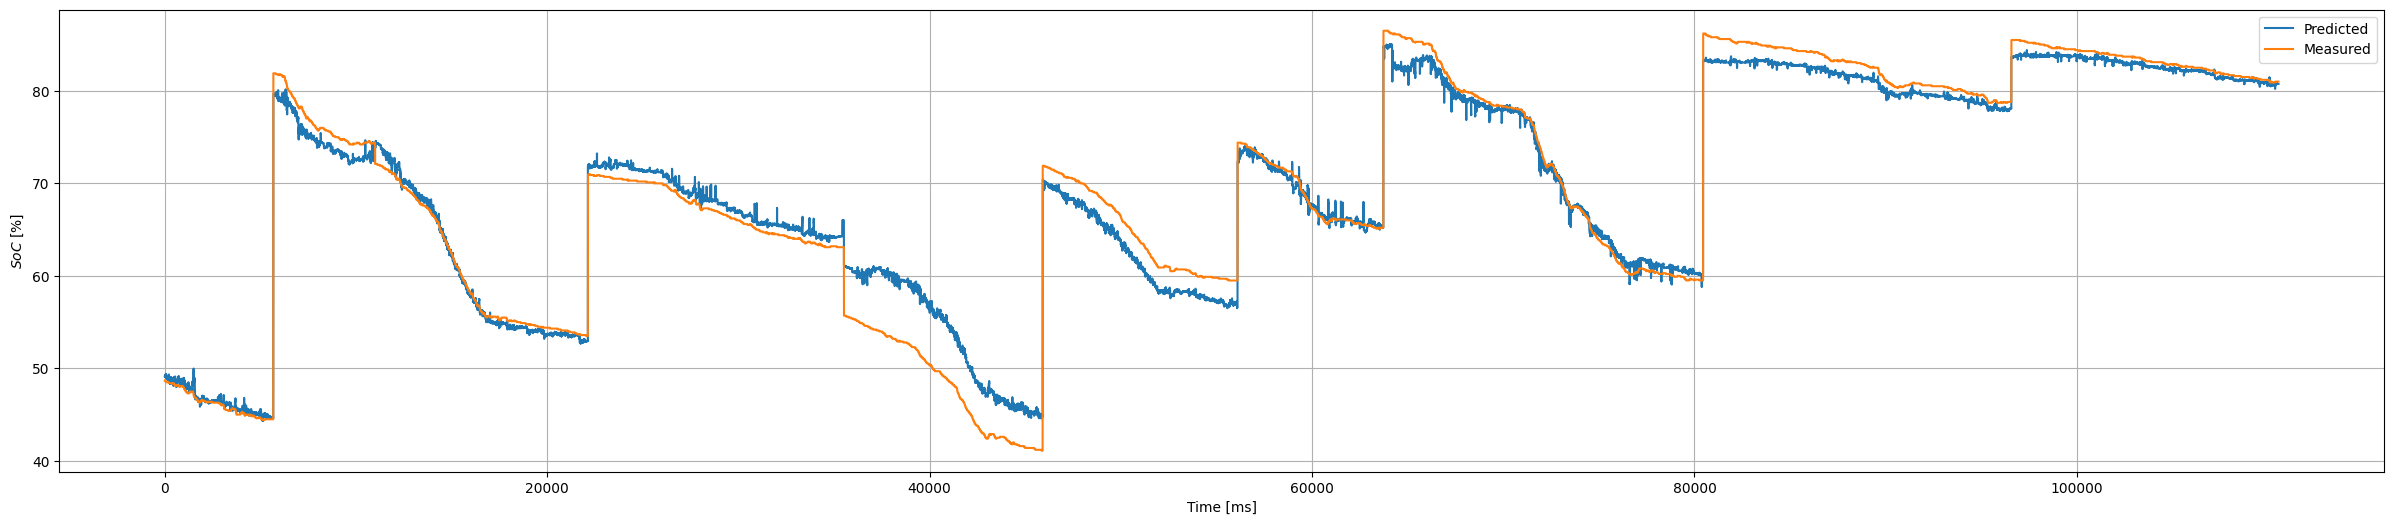

In [44]:
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Bidirectional, LSTM, Dense, Flatten, TimeDistributed

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the training data
X_train_norm = scaler.fit_transform(X_train)
# Normalize the testing data using the same scaler object
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

# Define the GRU model with L1 regularization
gru_model = Sequential([
    layers.GRU(64, input_shape=(X_train_norm.shape[1], 1),
               kernel_regularizer=regularizers.l1(0.01)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
])

# Define the Bi-LSTM model with one LSTM layer and L1/L2 regularization
lstm_input = Input(shape=(X_train_norm.shape[1], 1))
lstm_layer = Bidirectional(LSTM(32, return_sequences=True,
                                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))(lstm_input)
lstm_layer = TimeDistributed(Dense(16, activation='relu',
                                   kernel_regularizer=regularizers.l2(0.01)))(lstm_layer)
lstm_layer = Flatten()(lstm_layer)

# Combine the two models
combined_layer = concatenate([gru_model.output, lstm_layer])
final_layer = Dense(1)(combined_layer)
combined_model = Model(inputs=[gru_model.input, lstm_input], outputs=final_layer)

# Compile the model with early stopping
combined_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                       loss=losses.mae,
                       metrics=["mae"])

early_stopping = EarlyStopping(monitor='val_loss', patience=4)
# Train the model
history = combined_model.fit([X_train_norm, X_train_norm], y_train, epochs=50, verbose=1,
                             validation_data=([X_val_norm, X_val_norm], y_val),
                             callbacks=[early_stopping])

# Make predictions on the test set
y_pred_combined = combined_model.predict([X_test_norm, X_test_norm])

# Print the regression metrics and plot the results
print('Combined Model (GRU + Bi-LSTM):')
regression_metrics(y_test, y_pred_combined)
plot_comparison(y_test=y_test, y_pred=y_pred_combined, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)


In [ ]:
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Flatten, TimeDistributed, Dropout

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the training data
X_train_norm = scaler.fit_transform(X_train)
# Normalize the testing data using the same scaler object
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

# Define the CNN model with L2 regularization
cnn_input = Input(shape=(X_train_norm.shape[1], 1))
cnn_layer = Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01))(cnn_input)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Dropout(0.2)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

# Define the Bi-LSTM model with one LSTM layer and L1/L2 regularization
lstm_input = Input(shape=(X_train_norm.shape[1], 1))
lstm_layer = Bidirectional(LSTM(64, return_sequences=True,
                                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))(lstm_input)
lstm_layer = TimeDistributed(Dense(32, activation='relu',
                                   kernel_regularizer=regularizers.l2(0.01)))(lstm_layer)
lstm_layer = Flatten()(lstm_layer)

# Combine the two models
combined_layer = concatenate([cnn_layer, lstm_layer])
combined_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined_layer)
combined_layer = Dropout(0.2)(combined_layer)
final_layer = Dense(1)(combined_layer)
combined_model = Model(inputs=[cnn_input, lstm_input], outputs=final_layer)

# Compile the model with early stopping
combined_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                       loss=losses.mae,
                       metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
# Train the model
history = combined_model.fit([X_train_norm, X_train_norm], y_train, epochs=20, verbose=1,
                             validation_data=([X_val_norm, X_val_norm], y_val),
                             callbacks=[early_stopping])

# Make predictions on the test set
y_pred_combined = combined_model.predict([X_test_norm, X_test_norm])

# Print the regression metrics and plot the results
print('Combined Model (CNN + Bi-LSTM):')
regression_metrics(y_test, y_pred_combined)
plot_comparison(y_test=y_test, y_pred=y_pred_combined, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)

In [ ]:
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, GRU, Dense, Flatten, TimeDistributed

# Create a StandardScaler object
scaler = StandardScaler()

# Normalize the training data
X_train_norm = scaler.fit_transform(X_train)
# Normalize the validation data using the same scaler object
X_val_norm = scaler.transform(X_val)
# Normalize the testing data using the same scaler object
X_test_norm = scaler.transform(X_test)

# Define the CNN model
cnn_input = Input(shape=(X_train_norm.shape[1], 1))
cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Dropout(rate=0.2)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

# Define the GRU model with L1 regularization
gru_input = Input(shape=(X_train_norm.shape[1], 1))
gru_layer = layers.GRU(64, input_shape=(X_train_norm.shape[1], 1),
                       kernel_regularizer=regularizers.l1(0.01))(gru_input)
gru_layer = layers.Dense(32, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01))(gru_layer)

# Define the Bi-LSTM model with one LSTM layer and L1/L2 regularization
lstm_input = Input(shape=(X_train_norm.shape[1], 1))
lstm_layer = Bidirectional(LSTM(32, return_sequences=True,
                                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))(lstm_input)
lstm_layer = TimeDistributed(Dense(16, activation='relu',
                                   kernel_regularizer=regularizers.l2(0.01)))(lstm_layer)
lstm_layer = Flatten()(lstm_layer)

# Combine the three models
combined_layer = concatenate([cnn_layer, gru_layer, lstm_layer])
final_layer = Dense(1)(combined_layer)
combined_model = Model(inputs=[cnn_input, gru_input, lstm_input], outputs=final_layer)

# Compile the model with early stopping
combined_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                       loss=losses.mae,
                       metrics=["mae"])
early_stopping = EarlyStopping(monitor='val_loss', patience=8)

# Train the model
history = combined_model.fit([X_train_norm, X_train_norm, X_train_norm], y_train, epochs=50, verbose=1,
                             validation_data=([X_val_norm, X_val_norm, X_val_norm], y_val),
                             callbacks=[early_stopping])

# Evaluate the model on the test set
y_pred_combined = combined_model.predict([X_test_norm, X_test_norm, X_test_norm])
regression_metrics(y_test, y_pred_combined)
plot_comparison(y_test=y_test, y_pred=y_pred_combined, xlabel="Time [ms]", ylabel="$SoC$ [%]", dark_mode=False)

In [16]:
import matplotlib.pyplot as plt

plt.rcParams['agg.path.chunksize'] = 1000
plt.rcParams['path.simplify_threshold'] = 0.5